# Assignment: Stock Price Prediction

## Data
We are using data from a larger collection of stock data from [Kaggle](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs).


## Setup

In [1]:
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
%matplotlib inline

import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


## Load data

In [2]:
#get data from GitHub -> https://github.com/keuperj/DATA
!git clone https://github.com/keuperj/DATA.git

Cloning into 'DATA'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 126 (delta 11), reused 39 (delta 11), pack-reused 87 (from 1)
Receiving objects: 100% (126/126), 185.56 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (86/86), done.


In [3]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("DATA/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

<ipython-input-4-ddf1f5c272a1>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad', inplace=True)


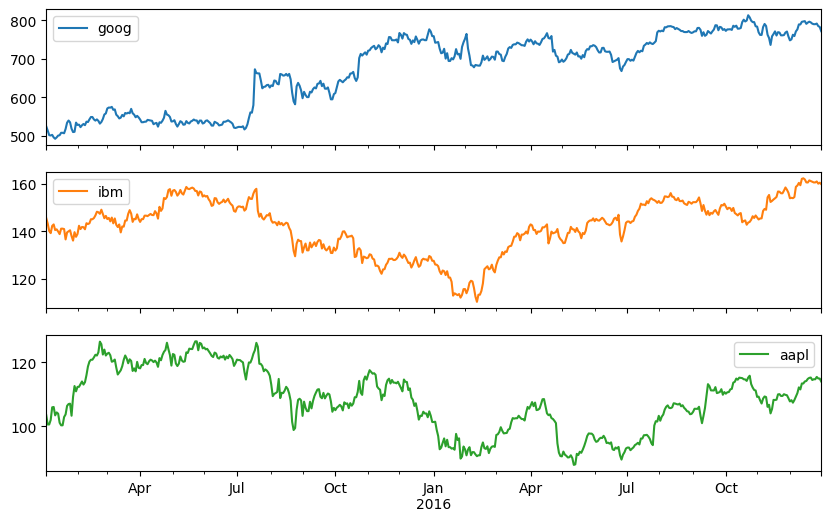

In [4]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad', inplace=True)
df.plot(figsize=(10, 6), subplots=True);

In [5]:
df.head()

,goog,ibm,aapl
2015-01-02,524.81,145.54,103.50
2015-01-05,513.87,143.24,100.58
2015-01-06,501.96,140.14,100.59
2015-01-07,501.10,139.23,102.01
2015-01-08,502.68,142.26,105.93


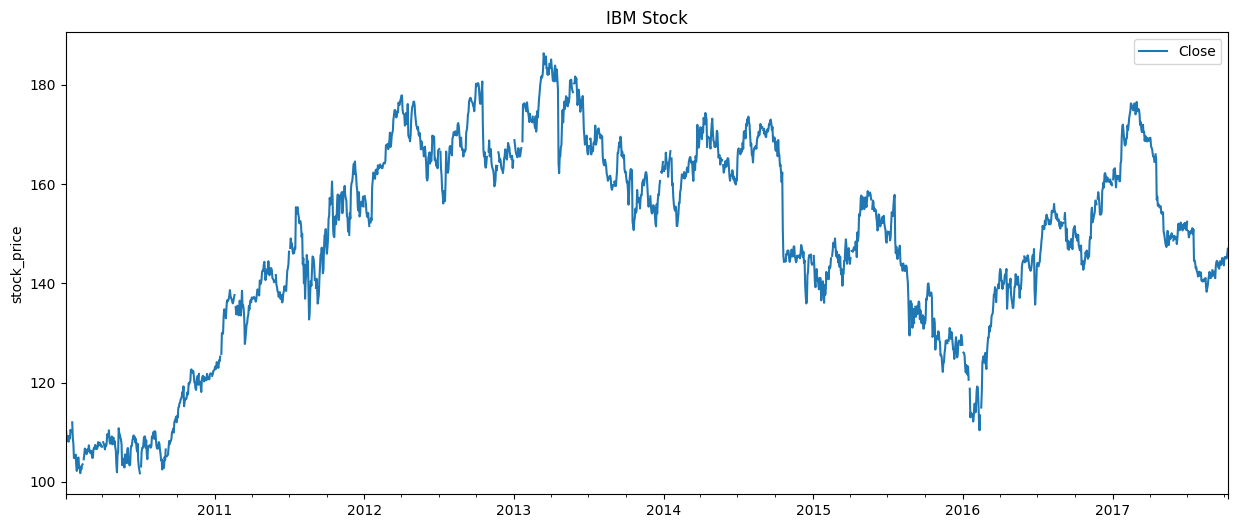

In [6]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("DATA/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [7]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 31.7 KB


In [8]:
#some pre-processing
df_ibm=df_ibm.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))


<ipython-input-8-b8ae6ac2b06d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ibm=df_ibm.fillna(method='ffill')


In [9]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1574, 59, 1)
y_train.shape =  (1574, 1)
x_test.shape =  (394, 59, 1)
y_test.shape =  (394, 1)


In [10]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [11]:
y_train.size(),x_train.size()

(torch.Size([1574, 1]), torch.Size([1574, 59, 1]))

## Assingment: Build LSTM
* build a PyTorch LSTM model
* train and evaluate
* plot prediction and true stock valaues

## Modell

In [19]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        # LSTM unit -> just one module for the full RNN grid setup!
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size*num_layers, num_classes)

    def forward(self, x):
        #init input
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size*num_layers)

        out = self.fc(h_out)

        return out


## Training

In [23]:
num_epochs = 2000
learning_rate = 0.01

lstm = LSTM(output_dim, input_dim, hidden_dim, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y_train)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.26512
Epoch: 100, loss: 0.23921
Epoch: 200, loss: 0.19560
Epoch: 300, loss: 0.15163
Epoch: 400, loss: 0.20930
Epoch: 500, loss: 0.19489
Epoch: 600, loss: 0.12213
Epoch: 700, loss: 0.18308
Epoch: 800, loss: 0.15813
Epoch: 900, loss: 0.12508
Epoch: 1000, loss: 0.11704
Epoch: 1100, loss: 0.09059
Epoch: 1200, loss: 0.08646
Epoch: 1300, loss: 0.07945
Epoch: 1400, loss: 0.07695
Epoch: 1500, loss: 0.07604
Epoch: 1600, loss: 0.07248
Epoch: 1700, loss: 0.07405
Epoch: 1800, loss: 0.07027
Epoch: 1900, loss: 0.07272


In [24]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y_train)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06693
Epoch: 100, loss: 0.07121
Epoch: 200, loss: 0.06731
Epoch: 300, loss: 0.06461
Epoch: 400, loss: 0.06494
Epoch: 500, loss: 0.08435
Epoch: 600, loss: 0.06408
Epoch: 700, loss: 0.06491
Epoch: 800, loss: 0.06319
Epoch: 900, loss: 0.06284
Epoch: 1000, loss: 0.06199
Epoch: 1100, loss: 0.06172
Epoch: 1200, loss: 0.13729
Epoch: 1300, loss: 0.08246
Epoch: 1400, loss: 0.07883
Epoch: 1500, loss: 0.06361
Epoch: 1600, loss: 0.05786
Epoch: 1700, loss: 0.05290
Epoch: 1800, loss: 0.03841
Epoch: 1900, loss: 0.03109


## Testing

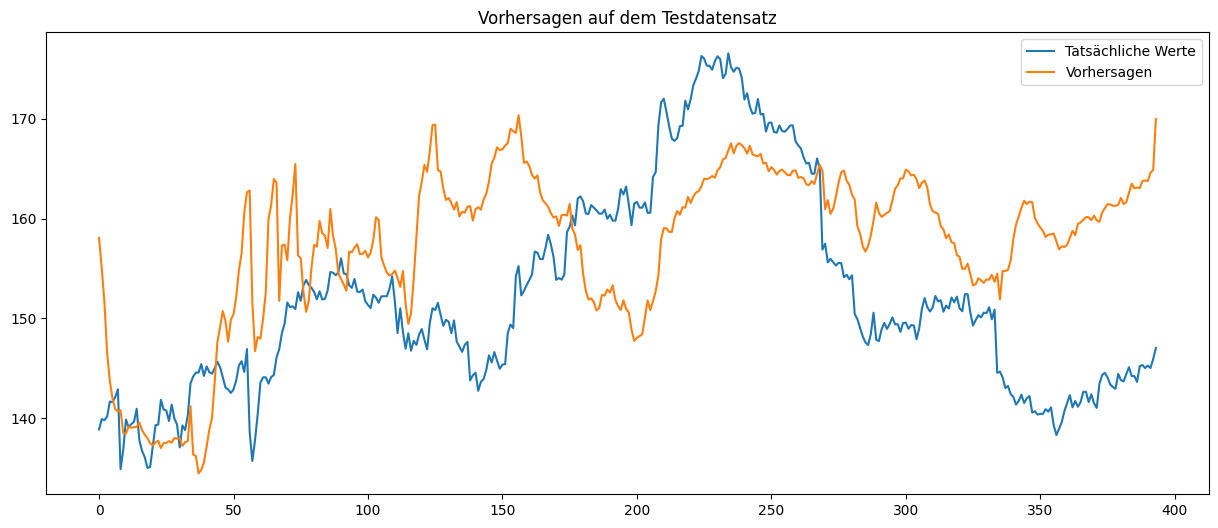

In [30]:
lstm.eval()
predictions = []

# Iteriere über alle Reihen im Testdatensatz
for i in range(x_test.shape[0]):
    # Extrahiere die i-te Reihe aus dem Testdatensatz
    input_sequence = x_test[i, :, :].unsqueeze(0)  # Füge eine Batch-Dimension hinzu

    # Erstelle eine Vorhersage für die i-te Reihe
    prediction = lstm(input_sequence)

    # Füge die Vorhersage zur Liste der Vorhersagen hinzu
    predictions.append(prediction.detach().numpy())  # Lösche den Gradienten und wandle in NumPy-Array um

# Wandle die Liste der Vorhersagen in ein NumPy-Array um
predictions = np.array(predictions).squeeze(1)  # Entferne die Batch-Dimension

# Inverse Transformation für die Vorhersagen
predictions = scaler.inverse_transform(predictions)

# Inverse Transformation für die tatsächlichen Werte
actual_values = scaler.inverse_transform(y_test.data.numpy())

# Erstelle ein Diagramm mit allen Vorhersagen und tatsächlichen Werten
plt.figure(figsize=(15, 6))
plt.plot(actual_values, label="Tatsächliche Werte")
plt.plot(predictions, label="Vorhersagen")
plt.title("Vorhersagen auf dem Testdatensatz")
plt.legend()
plt.show()

In [43]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 90 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

# make training and test sets in torch
x_train2 = torch.from_numpy(x_train).type(torch.Tensor)
x_test2 = torch.from_numpy(x_test).type(torch.Tensor)
y_train2 = torch.from_numpy(y_train).type(torch.Tensor)
y_test2 = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (1550, 89, 1)
y_train.shape =  (1550, 1)
x_test.shape =  (388, 89, 1)
y_test.shape =  (388, 1)


In [44]:
num_epochs = 2000
learning_rate = 0.01

lstm2 = LSTM(output_dim, input_dim, hidden_dim, num_layers)

criterion2 = torch.nn.MSELoss()    # mean-squared error for regression
optimizer2 = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)

In [46]:
# Train the model
for epoch2 in range(num_epochs):
    outputs2 = lstm2(x_train2)
    optimizer2.zero_grad()

    # obtain the loss function
    loss2 = criterion2(outputs2, y_train2)

    loss2.backward()

    optimizer2.step()
    if epoch2 % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch2, loss2.item()))

Epoch: 0, loss: 0.13230
Epoch: 100, loss: 0.13322
Epoch: 200, loss: 0.11793
Epoch: 300, loss: 0.20523
Epoch: 400, loss: 0.24392
Epoch: 500, loss: 0.21750
Epoch: 600, loss: 0.13060
Epoch: 700, loss: 0.13102
Epoch: 800, loss: 0.13168
Epoch: 900, loss: 0.12952
Epoch: 1000, loss: 0.12591
Epoch: 1100, loss: 0.12082
Epoch: 1200, loss: 0.11483
Epoch: 1300, loss: 0.16563
Epoch: 1400, loss: 0.12646
Epoch: 1500, loss: 0.11338
Epoch: 1600, loss: 0.09334
Epoch: 1700, loss: 0.11366
Epoch: 1800, loss: 0.07555
Epoch: 1900, loss: 0.12752


In [ ]:
lstm2.eval()
predictions = []

# Iteriere über alle Reihen im Testdatensatz
for i in range(x_test.shape[0]):
    # Extrahiere die i-te Reihe aus dem Testdatensatz
    input_sequence = x_test[i, :, :].unsqueeze(0)  # Füge eine Batch-Dimension hinzu

    # Erstelle eine Vorhersage für die i-te Reihe
    prediction = lstm2(input_sequence)

    # Füge die Vorhersage zur Liste der Vorhersagen hinzu
    predictions.append(prediction.detach().numpy())  # Lösche den Gradienten und wandle in NumPy-Array um

# Wandle die Liste der Vorhersagen in ein NumPy-Array um
predictions = np.array(predictions).squeeze(1)  # Entferne die Batch-Dimension

# Inverse Transformation für die Vorhersagen
predictions = scaler.inverse_transform(predictions)

# Inverse Transformation für die tatsächlichen Werte
actual_values = scaler.inverse_transform(y_test.data.numpy())

# Erstelle ein Diagramm mit allen Vorhersagen und tatsächlichen Werten
plt.figure(figsize=(15, 6))
plt.plot(actual_values, label="Tatsächliche Werte")
plt.plot(predictions, label="Vorhersagen")
plt.title("Vorhersagen auf dem Testdatensatz")
plt.legend()
plt.show()